# import Libraries


In [80]:
import re
import time
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



# Extracting

In [111]:

s = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=s)

urls = [
    "https://www.imdb.com/list/ls048276758/",
    "https://www.imdb.com/list/ls048276758/?page=2",
    "https://www.imdb.com/list/ls048276758/?page=3",
    "https://www.imdb.com/list/ls048276758/?page=4"
]

movie_data = []

for url in urls:
    driver.get(url)

    wait = WebDriverWait(driver, 30)
    wait.until(EC.presence_of_all_elements_located((By.XPATH, "//div[@data-testid='list-page-mc-list-content']")))

    scroll_pause_time = 3
    screen_height = driver.execute_script("return window.screen.height;")

    current_height = driver.execute_script("return document.body.scrollHeight")
    while True:
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(scroll_pause_time)
        new_height = driver.execute_script("return document.body.scrollHeight")
        if new_height == current_height:
            break
        current_height = new_height

    movie_elements = driver.find_elements(By.XPATH, "//div[@class='sc-2bfd043a-3 jpWwpQ dli-parent']")

    for movie in movie_elements:
        movie_info = {}
        try:
            full_title = movie.find_element(By.XPATH, ".//h3[@class='ipc-title__text']").text
            if '.' in full_title:
                movie_info["id"] = full_title.split('.')[0].strip()
                movie_info["title"] = full_title.split('.', 1)[1].strip()
            else:
                movie_info["id"] = full_title[:3].strip()
                movie_info["title"] = full_title[3:].strip()
        except Exception:
            movie_info["id"] = "N/A"
            movie_info["title"] = "N/A"

        try:
            metadata_elements = movie.find_elements(By.XPATH, ".//div[@class='sc-300a8231-6 dBUjvq dli-title-metadata']/span")
            movie_info["year"] = metadata_elements[0].text if len(metadata_elements) > 0 else "N/A"
            movie_info["duration"] = metadata_elements[1].text if len(metadata_elements) > 1 else "N/A"
            movie_info["certification"] = metadata_elements[2].text if len(metadata_elements) > 2 else "N/A"

            duration_hours = re.search(r'(\d+)h', movie_info["duration"])
            duration_minutes = re.search(r'(\d+)m', movie_info["duration"])
            hours = duration_hours.group(1) if duration_hours else "0"
            minutes = duration_minutes.group(1) if duration_minutes else "0"
            movie_info["duration"] = f"{hours}h {minutes}m" if hours != "0" or minutes != "0" else "N/A"
        except Exception:
            movie_info["year"] = "N/A"
            movie_info["duration"] = "N/A"
            movie_info["certification"] = "N/A"

        try:
            movie_info["rating"] = movie.find_element(By.XPATH, ".//span[@class='ipc-rating-star--rating']").text
        except Exception:
            movie_info["rating"] = "N/A"

        try:
            voteCount = movie.find_element(By.XPATH, ".//span[@class='ipc-rating-star--voteCount']").text
            movie_info["voteCount"] = re.sub(r'[()]+', '', voteCount).strip()
        except Exception:
            movie_info["voteCount"] = "N/A"

        try:
            movie_info["Metascore"] = movie.find_element(By.XPATH, ".//span[@class='sc-b0901df4-0 bXIOoL metacritic-score-box']").text
        except Exception:
            movie_info["Metascore"] = "N/A"

        try:
            movie_info["Description"] = movie.find_element(By.XPATH, ".//div[@class='ipc-html-content ipc-html-content--base sc-2bfd043a-0 bktZnv dli-plot-container']").text
        except Exception:
            movie_info["Description"] = "N/A"

        movie_info["Director"] = "N/A"
        movie_info["Stars"] = "N/A"

        try:
            director_element = movie.find_element(By.XPATH, ".//span[contains(text(), 'Director')]/following-sibling::span/a")
            movie_info["Director"] = director_element.text if director_element else "N/A"
        except Exception:
            movie_info["Director"] = "N/A"

        try:
            stars_elements = movie.find_elements(By.XPATH, ".//span[contains(text(), 'Stars')]/following-sibling::span/a")
            movie_info["Stars"] = ", ".join([star.text for star in stars_elements]) if stars_elements else "N/A"
        except Exception:
            movie_info["Stars"] = "N/A"

        try:
            link_element = movie.find_element(By.XPATH, ".//a[@class='ipc-lockup-overlay ipc-focusable']")
            movie_info["movielink"] = link_element.get_attribute('href') if link_element else "N/A"
        except Exception:
            movie_info["movielink"] = "N/A"

        movie_data.append(movie_info)

df = pd.DataFrame(movie_data)
display(df)
df.to_excel("imdb_movies_combined.xlsx", index=False)
df.to_csv("imdb_movies_combined.csv", index=False)

driver.quit()

,id,title,year,duration,certification,rating,voteCount,Metascore,Description,Director,Stars,movielink
0,1,The Godfather,1972,2h 55m,R,9.2,2.1M,100,The aging patriarch of an organized crime dyna...,Francis Ford Coppola,"Marlon Brando, Al Pacino, James Caan",https://www.imdb.com/title/tt0068646/?ref_=ls_i_1
1,2,Tokyo Story,1953,2h 17m,Not Rated,8.1,72K,100,An old couple visit their children and grandch...,Yasujirô Ozu,"Chishû Ryû, Chieko Higashiyama, Sô Yamamura",https://www.imdb.com/title/tt0046438/?ref_=ls_i_2
2,3,Seven Samurai,1954,3h 27m,Not Rated,8.6,378K,98,Farmers from a village exploited by bandits hi...,Akira Kurosawa,"Toshirô Mifune, Takashi Shimura, Keiko Tsushima",https://www.imdb.com/title/tt0047478/?ref_=ls_i_3
3,4,The Godfather Part II,1974,3h 22m,R,9.0,1.4M,90,The early life and career of Vito Corleone in ...,Francis Ford Coppola,"Al Pacino, Robert De Niro, Robert Duvall",https://www.imdb.com/title/tt0071562/?ref_=ls_i_4
4,5,Casablanca,1942,1h 42m,PG,8.5,622K,100,A cynical expatriate American cafe owner strug...,Michael Curtiz,"Humphrey Bogart, Ingrid Bergman, Paul Henreid",https://www.imdb.com/title/tt0034583/?ref_=ls_i_5
...,...,...,...,...,...,...,...,...,...,...,...,...
994,995,Cold Water,1994,1h 35m,Not Rated,7.0,2.3K,90,When the girl of a rebelious teenage couple fi...,Olivier Assayas,"Virginie Ledoyen, Cyprien Fouquet, László Szabó",https://www.imdb.com/title/tt0109702/?ref_=ls_...
995,996,We the Animals,2018,1h 34m,R,6.9,4.7K,80,"Manny, Joel, and Jonah tear their way through ...",Jeremiah Zagar,"Evan Rosado, Raúl Castillo, Sheila Vand",https://www.imdb.com/title/tt7681824/?ref_=ls_...
996,997,David Holzman's Diary,1967,1h 14m,Not Rated,6.5,1.9K,N/A,A young filmmaker decides to make a movie of h...,Jim McBride,"L.M. Kit Carson, Eileen Dietz, Louise Levine",https://www.imdb.com/title/tt0062864/?ref_=ls_...
997,998,Moonrise,1948,1h 30m,Approved,7.0,3.1K,N/A,Danny is despised by his schoolmates because h...,Frank Borzage,"Dane Clark, Gail Russell, Ethel Barrymore",https://www.imdb.com/title/tt0040607/?ref_=ls_...


### preprocessing

In [210]:
# Read the CSV file
file_path = 'imdb_movies_combined.csv'  # Replace with your CSV file path
df = pd.read_csv(file_path)

# preprocessing and cleaning
# Function to convert 'xh ym' format to total minutes
def time_to_minutes(time_str):
    if pd.isna(time_str):  # Handle missing values
        return None
    time_str = str(time_str)  # Ensure the value is treated as a string
    match = re.match(r"(\d+)h (\d+)m", time_str)
    if match:
        hours, minutes = map(int, match.groups())  # Extract and convert to integers
        total_minutes = hours * 60 + minutes       # Convert to total minutes
        return total_minutes
    return None  # Return None for invalid format

# Function to convert values like 2.1M and 71K into real numbers
def convert_vote_count(vote_count):
    if isinstance(vote_count, str):
        if 'M' in vote_count:
            return float(vote_count.replace('M', '').strip()) * 1_000_000
        elif 'K' in vote_count:
            return float(vote_count.replace('K', '').strip()) * 1_000
        else:
            try:
                return int(vote_count)  # If the value does not contain K or M, convert it to an integer
            except ValueError:
                return 0  # If the value cannot be converted, return 0
    return 0



# extract the first year only from the rows which contain more than one value
df['year'] = df['year'].str.extract(r'(\d{4})', expand=False)

# Apply the conversion and create a new column 'duration_minutes'
df['duration'] = df['duration'].apply(time_to_minutes)
df['voteCount'] = df['voteCount'].apply(convert_vote_count)

display(df)
print(df.info())

,id,title,year,duration,certification,rating,voteCount,Metascore,Description,Director,Stars,movielink
0,1,The Godfather,1972,175.0,R,9.2,2100000.0,100.0,The aging patriarch of an organized crime dyna...,Francis Ford Coppola,"Marlon Brando, Al Pacino, James Caan",https://www.imdb.com/title/tt0068646/?ref_=ls_i_1
1,2,Tokyo Story,1953,137.0,Not Rated,8.1,71000.0,100.0,An old couple visit their children and grandch...,Yasujirô Ozu,"Chishû Ryû, Chieko Higashiyama, Sô Yamamura",https://www.imdb.com/title/tt0046438/?ref_=ls_i_2
2,3,Seven Samurai,1954,207.0,Not Rated,8.6,376000.0,98.0,Farmers from a village exploited by bandits hi...,Akira Kurosawa,"Toshirô Mifune, Takashi Shimura, Keiko Tsushima",https://www.imdb.com/title/tt0047478/?ref_=ls_i_3
3,4,The Godfather Part II,1974,202.0,R,9.0,1400000.0,90.0,The early life and career of Vito Corleone in ...,Francis Ford Coppola,"Al Pacino, Robert De Niro, Robert Duvall",https://www.imdb.com/title/tt0071562/?ref_=ls_i_4
4,5,Casablanca,1942,102.0,PG,8.5,620000.0,100.0,A cynical expatriate American cafe owner strug...,Michael Curtiz,"Humphrey Bogart, Ingrid Bergman, Paul Henreid",https://www.imdb.com/title/tt0034583/?ref_=ls_i_5
...,...,...,...,...,...,...,...,...,...,...,...,...
994,995,Cold Water,1994,95.0,Not Rated,7.0,2300.0,90.0,When the girl of a rebelious teenage couple fi...,Olivier Assayas,"Virginie Ledoyen, Cyprien Fouquet, László Szabó",https://www.imdb.com/title/tt0109702/?ref_=ls_...
995,996,We the Animals,2018,94.0,R,6.9,4700.0,80.0,"Manny, Joel, and Jonah tear their way through ...",Jeremiah Zagar,"Evan Rosado, Raúl Castillo, Sheila Vand",https://www.imdb.com/title/tt7681824/?ref_=ls_...
996,997,David Holzman's Diary,1967,74.0,Not Rated,6.5,1900.0,NaN,A young filmmaker decides to make a movie of h...,Jim McBride,"L.M. Kit Carson, Eileen Dietz, Louise Levine",https://www.imdb.com/title/tt0062864/?ref_=ls_...
997,998,Moonrise,1948,90.0,Approved,7.0,3100.0,NaN,Danny is despised by his schoolmates because h...,Frank Borzage,"Dane Clark, Gail Russell, Ethel Barrymore",https://www.imdb.com/title/tt0040607/?ref_=ls_...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             999 non-null    int64  
 1   title          999 non-null    object 
 2   year           999 non-null    object 
 3   duration       992 non-null    float64
 4   certification  937 non-null    object 
 5   rating         999 non-null    float64
 6   voteCount      999 non-null    float64
 7   Metascore      629 non-null    float64
 8   Description    999 non-null    object 
 9   Director       992 non-null    object 
 10  Stars          995 non-null    object 
 11  movielink      999 non-null    object 
dtypes: float64(4), int64(1), object(7)
memory usage: 93.8+ KB
None


In [171]:
# Split the column containing the stars into separate columns
# Assuming the column with stars is named 'Stars'
stars_split = df['Stars'].str.split(',', expand=True)

#stars_split = df['Stars'].str.extract(r'([^,]+),\s*([^,]+),\s*([^,]+)')

# Rename the columns if needed (e.g., Star1, Star2, Star3)
stars_split.columns = ['Star1', 'Star2', 'Star3']

# Find the index of the 'Stars' column
stars_index = df.columns.get_loc('Stars')

# Drop the original 'Stars' column
df = df.drop('Stars', axis=1)

# Insert the new columns at the original position of the 'Stars' column
for i, col in enumerate(stars_split.columns):
    df.insert(stars_index + i, col, stars_split[col])
df.head(5)


,id,title,year,duration,certification,rating,voteCount,Metascore,Description,Director,Star1,Star2,Star3,movielink
0,1,The Godfather,1972,175.0,R,9.2,2100000.0,100.0,The aging patriarch of an organized crime dyna...,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,https://www.imdb.com/title/tt0068646/?ref_=ls_i_1
1,2,Tokyo Story,1953,137.0,Not Rated,8.1,71000.0,100.0,An old couple visit their children and grandch...,Yasujirô Ozu,Chishû Ryû,Chieko Higashiyama,Sô Yamamura,https://www.imdb.com/title/tt0046438/?ref_=ls_i_2
2,3,Seven Samurai,1954,207.0,Not Rated,8.6,376000.0,98.0,Farmers from a village exploited by bandits hi...,Akira Kurosawa,Toshirô Mifune,Takashi Shimura,Keiko Tsushima,https://www.imdb.com/title/tt0047478/?ref_=ls_i_3
3,4,The Godfather Part II,1974,202.0,R,9.0,1400000.0,90.0,The early life and career of Vito Corleone in ...,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,https://www.imdb.com/title/tt0071562/?ref_=ls_i_4
4,5,Casablanca,1942,102.0,PG,8.5,620000.0,100.0,A cynical expatriate American cafe owner strug...,Michael Curtiz,Humphrey Bogart,Ingrid Bergman,Paul Henreid,https://www.imdb.com/title/tt0034583/?ref_=ls_i_5


In [172]:
#To determine whether there ara duplicated rows
print(df.duplicated().sum())

0


In [173]:
print(df.isna().sum()) # determine the sum of null values in each column

id                 0
title              0
year               0
duration           7
certification     62
rating             0
voteCount          0
Metascore        370
Description        0
Director           7
Star1              4
Star2              5
Star3             11
movielink          0
dtype: int64


In [174]:
#To determine the columns which contain null values
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             999 non-null    int64  
 1   title          999 non-null    object 
 2   year           999 non-null    object 
 3   duration       992 non-null    float64
 4   certification  937 non-null    object 
 5   rating         999 non-null    float64
 6   voteCount      999 non-null    float64
 7   Metascore      629 non-null    float64
 8   Description    999 non-null    object 
 9   Director       992 non-null    object 
 10  Star1          995 non-null    object 
 11  Star2          994 non-null    object 
 12  Star3          988 non-null    object 
 13  movielink      999 non-null    object 
dtypes: float64(4), int64(1), object(9)
memory usage: 109.4+ KB
None


In [175]:
df = df.dropna(subset=['duration']) # Remove rows where the 'duration' column has missing values
df['certification'] = df['certification'].fillna('Not Rated') # replace the null values in certification column to "Not Rated"

In [176]:
# Define the columns to be used
features = ['rating', 'Metascore']

# Convert the specified columns to numeric (if not already)
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
df['Metascore'] = pd.to_numeric(df['Metascore'], errors='coerce')

# Create a temporary subset of the columns to be imputed
data_for_imputation = df[features]

# Create a KNNImputer
knn_imputer = KNNImputer(n_neighbors=5)

# Apply KNN imputation directly on the original data
data_imputed = knn_imputer.fit_transform(data_for_imputation)

# Update the original columns with the imputed values
df['Metascore'] = data_imputed[:, 1]

In [177]:
df = df.dropna(subset=['Star1'])  # Remove rows where the 'Star1' column has missing values
df = df.dropna(subset=['Star2'])  # Remove rows where the 'Star2' column has missing values
df = df.dropna(subset=['Star3'])  # Remove rows where the 'Star3' column has missing values

In [178]:
print(df.isna().sum()) # determine the sum of null values in each column

id               0
title            0
year             0
duration         0
certification    0
rating           0
voteCount        0
Metascore        0
Description      0
Director         0
Star1            0
Star2            0
Star3            0
movielink        0
dtype: int64


In [179]:
df['Metascore'] = pd.to_numeric(df['Metascore']).astype(int)  # convert the data type of 'Metascore' column to integer
df['voteCount'] = pd.to_numeric(df['voteCount']).astype(int)  # convert the data type of 'voteCount' column to integer
df['duration'] = pd.to_numeric(df['duration']).astype(int)  # convert the data type of 'duration' column to integer
df['year'] = pd.to_numeric(df['year']).astype(int) # convert the data type of 'year' column to integer

In [180]:
df.info() # To ensure that the data types have been changed

<class 'pandas.core.frame.DataFrame'>
Index: 981 entries, 0 to 998
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             981 non-null    int64  
 1   title          981 non-null    object 
 2   year           981 non-null    int32  
 3   duration       981 non-null    int32  
 4   certification  981 non-null    object 
 5   rating         981 non-null    float64
 6   voteCount      981 non-null    int32  
 7   Metascore      981 non-null    int32  
 8   Description    981 non-null    object 
 9   Director       981 non-null    object 
 10  Star1          981 non-null    object 
 11  Star2          981 non-null    object 
 12  Star3          981 non-null    object 
 13  movielink      981 non-null    object 
dtypes: float64(1), int32(4), int64(1), object(8)
memory usage: 99.6+ KB


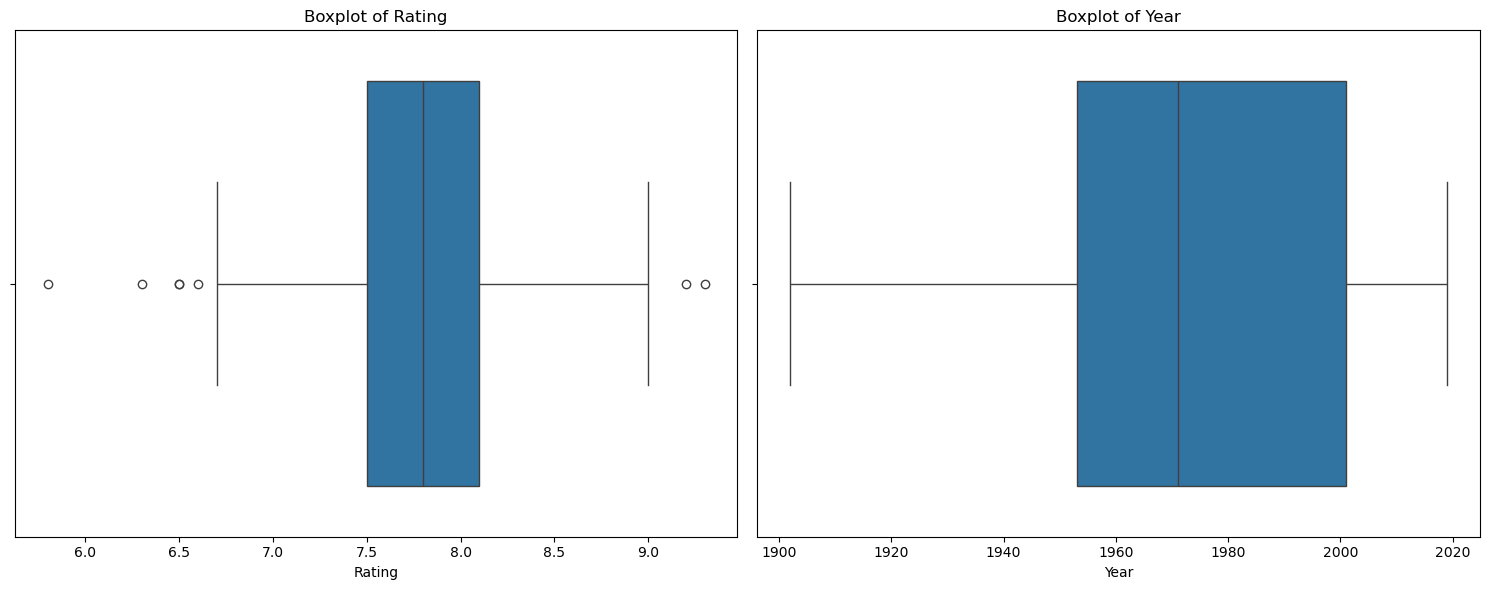

In [181]:
# draw boxblot of rating and year and metascore to determine if there are outliers in these columns
# Create a figure with 1 row and 2 columns (to display two boxplots side by side)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Draw the Boxplot for the 'rating' column in the first subplot (left)
sns.boxplot(x=df['rating'], ax=axes[0])  # Plot the boxplot for 'rating'
axes[0].set_title('Boxplot of Rating')  # Set the title for the first subplot
axes[0].set_xlabel('Rating')  # Label the x-axis of the first subplot

# Draw the Boxplot for the 'year' column in the second subplot (right)
sns.boxplot(x=df['year'], ax=axes[1])  # Plot the boxplot for 'year'
axes[1].set_title('Boxplot of Year')  # Set the title for the second subplot
axes[1].set_xlabel('Year')  # Label the x-axis of the second subplot

# Adjust layout to ensure the subplots don't overlap
plt.tight_layout()

# Display the figure
plt.show()

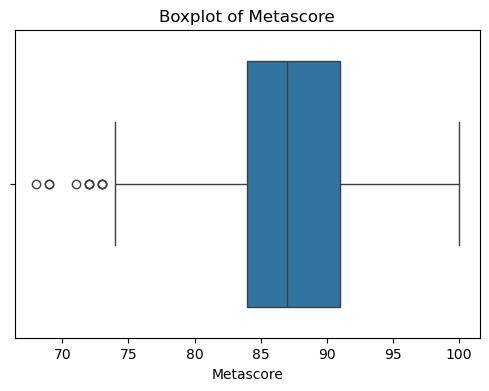

In [182]:
# creating a Boxplot for the 'Metascore' column
plt.figure(figsize=(6, 4))  # Set the figure size to 8x6 inches
sns.boxplot(x=df['Metascore'])  # Plot the boxplot for the 'Metascore' column
plt.title('Boxplot of Metascore')  # Add a title to the plot
plt.xlabel('Metascore')  # Label the x-axis as 'Metascore'
plt.show()  # Display the plot

In [183]:
# Print the unique values in the 'certification' column to check for outliers
print(df['certification'].unique())  

['R' 'Not Rated' 'PG' 'Approved' 'G' 'Passed' 'TV-14' 'PG-13' 'TV-G' 'GP'
 'TV-PG' 'Unrated' 'TV-MA' 'M/PG' 'NC-17']


In [184]:
#To reset the ID column after deleting some columns
df['id'] = range(1, len(df) + 1)

In [185]:
# Select only numeric columns
numeric_df = df.select_dtypes(include=['number'])

# Compute the correlation matrix for numeric columns
corr_matrix = numeric_df.corr()

# Apply the background gradient
corr_matrix.style.background_gradient()


,id,year,duration,rating,voteCount,Metascore
id,1.000000,0.220591,-0.151146,-0.653491,-0.166193,-0.355338
year,0.220591,1.000000,0.148881,-0.007553,0.309811,-0.159969
duration,-0.151146,0.148881,1.000000,0.231665,0.139246,0.065921
rating,-0.653491,-0.007553,0.231665,1.000000,0.501263,0.125230
voteCount,-0.166193,0.309811,0.139246,0.501263,1.000000,-0.006170
Metascore,-0.355338,-0.159969,0.065921,0.125230,-0.006170,1.000000


### Viusalization

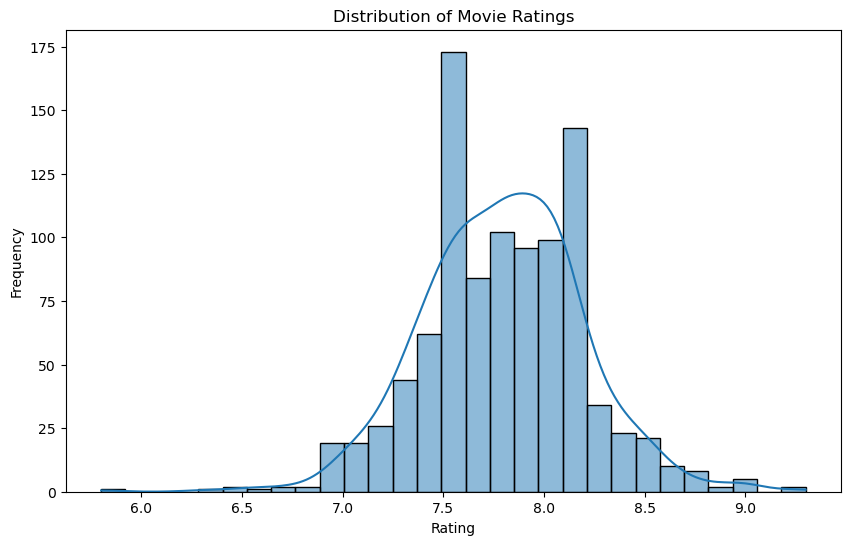

In [186]:
# Create a histogram with a kernel density estimate (KDE) for the 'rating' column.
plt.figure(figsize=(10, 6))  # Set the figure size.
sns.histplot(df['rating'], kde=True)  # Plot the histogram with KDE for the 'rating' column.
plt.title('Distribution of Movie Ratings')  # Add a title to the plot.
plt.xlabel('Rating')  # Label the x-axis as 'Rating'.
plt.ylabel('Frequency')  # Label the y-axis as 'Frequency'.
plt.show()  # Display the plot.

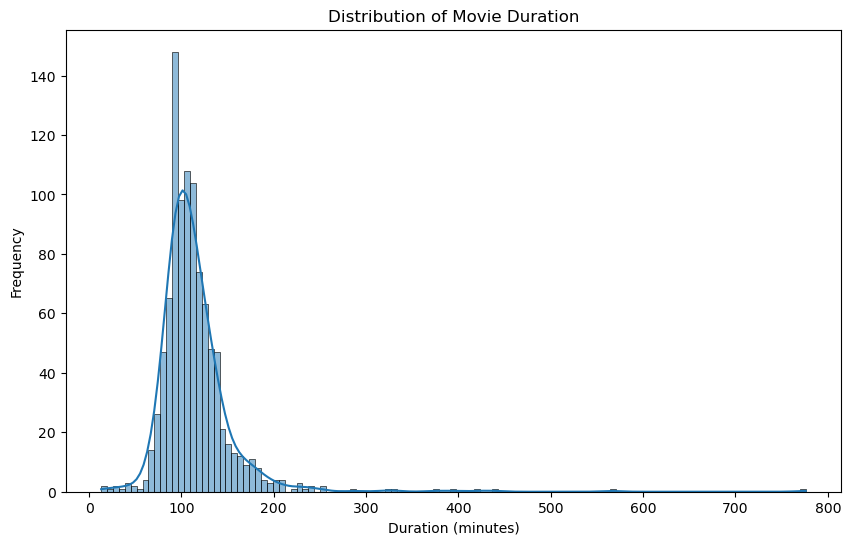

In [187]:
# Create a histogram with a kernel density estimate (KDE) for the 'duration' column.
plt.figure(figsize=(10, 6))  # Set the figure size.
sns.histplot(df['duration'], kde=True)  # Plot the histogram with KDE for the 'duration' column.
plt.title('Distribution of Movie Duration')  # Add a title to the plot.
plt.xlabel('Duration (minutes)')  # Label the x-axis as 'Duration (minutes)'.
plt.ylabel('Frequency')  # Label the y-axis as 'Frequency'.
plt.show()  # Display the plot.

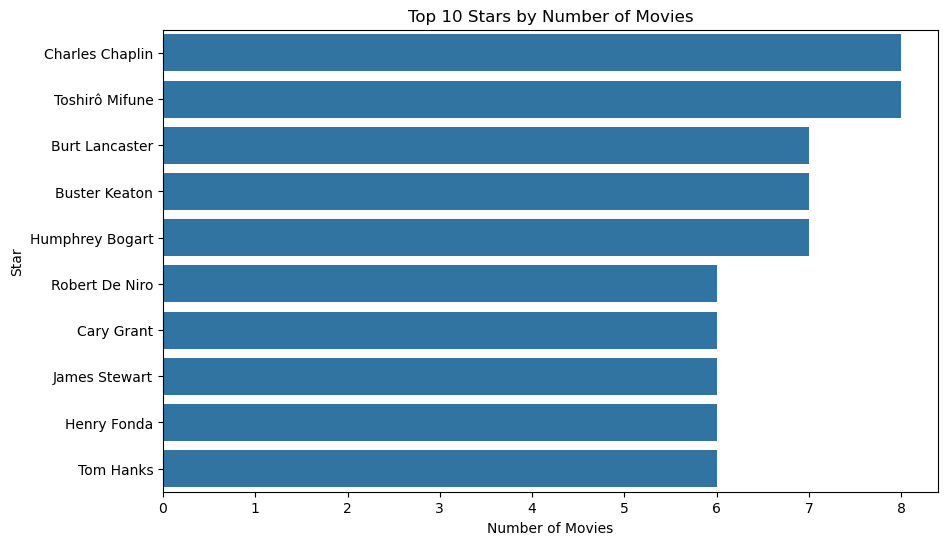

In [188]:
# Concatenate the values of 'Star1', 'Star2', and 'Star3' columns into one series.
top_stars = pd.concat([df['Star1'], df['Star2'], df['Star3']])

# Count the occurrences of each star and get the top 10 stars with the most movies.
top_stars = top_stars.value_counts().head(10)

# Create a bar plot with the top 10 stars and their corresponding movie count.
plt.figure(figsize=(10, 6))  # Set the figure size.
sns.barplot(x=top_stars.values, y=top_stars.index)  # Create the bar plot.
plt.title('Top 10 Stars by Number of Movies')  # Add a title to the plot.
plt.xlabel('Number of Movies')  # Label the x-axis as 'Number of Movies'.
plt.ylabel('Star')  # Label the y-axis as 'Star'.
plt.show()  # Display the plot.

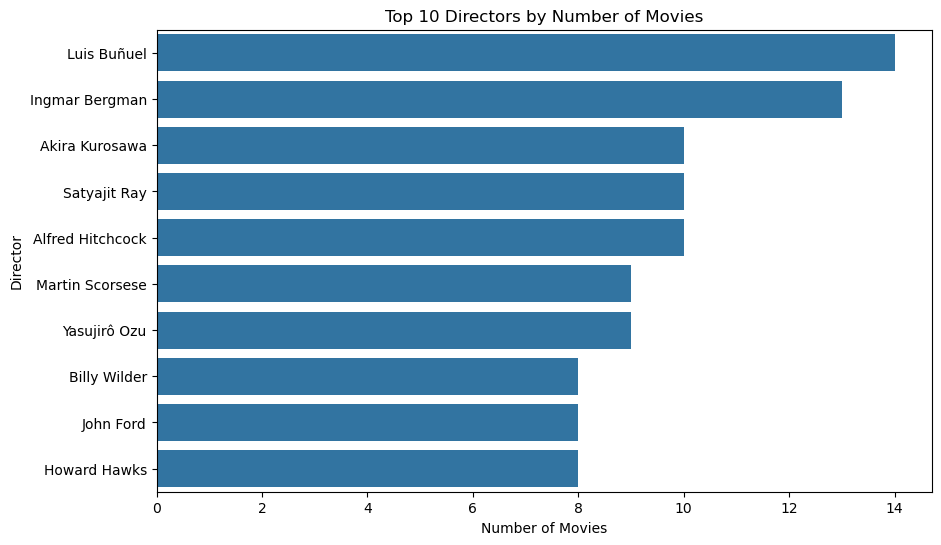

In [189]:
# Count the occurrences of each director and get the top 10 directors with the most movies.
top_directors = df['Director'].value_counts().head(10)

# Create a bar plot with the top 10 directors and their corresponding movie count.
plt.figure(figsize=(10, 6))  # Set the figure size.
sns.barplot(x=top_directors.values, y=top_directors.index)  # Create the bar plot.
plt.title('Top 10 Directors by Number of Movies')  # Add a title to the plot.
plt.xlabel('Number of Movies')  # Label the x-axis as 'Number of Movies'.
plt.ylabel('Director')  # Label the y-axis as 'Director'.
plt.show()  # Display the plot.

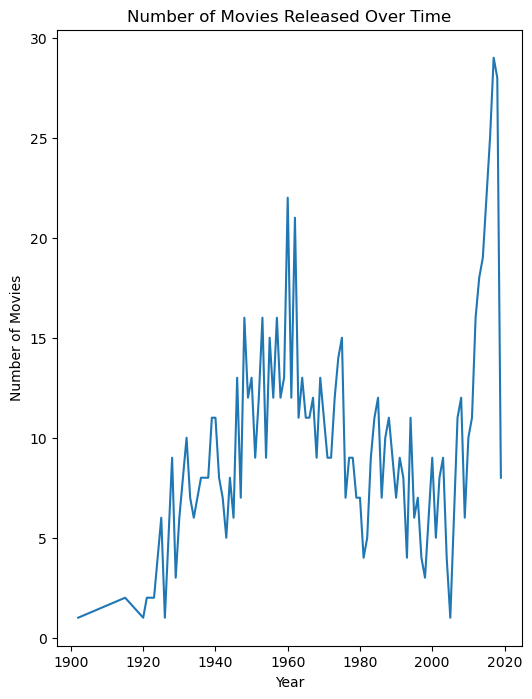

In [190]:
year_counts = df['year'].value_counts().sort_index()

plt.figure(figsize=(6, 8))
sns.lineplot(x=year_counts.index, y=year_counts.values)
plt.title('Number of Movies Released Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.show()

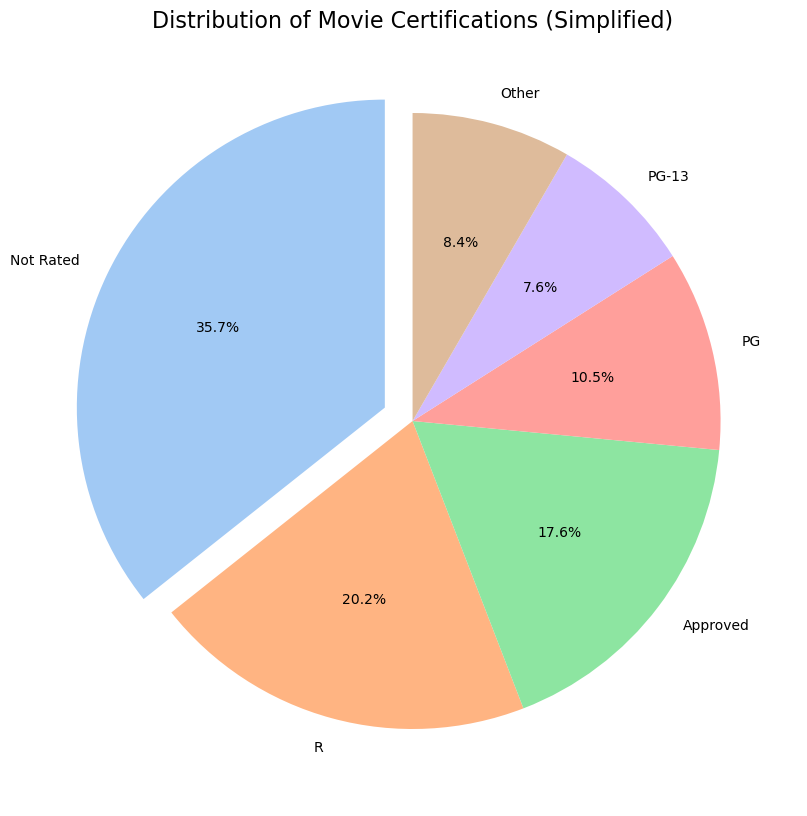

In [191]:
# Count the number of movies for each certification category
certification_counts = df['certification'].value_counts()

# Calculate the total number of movies
total_movies = certification_counts.sum()

# Select certifications with a frequency greater than or equal to 5% of the total movies
significant_certifications = certification_counts[certification_counts / total_movies >= 0.05]

# Select certifications with a frequency less than 5%
other_certifications = certification_counts[certification_counts / total_movies < 0.05]

# Merge the less common certifications into an 'Other' category
certifications = significant_certifications.copy()
if not other_certifications.empty:
    certifications['Other'] = other_certifications.sum()

# Create a pie chart to show the distribution of movie certifications
plt.figure(figsize=(10, 10))
plt.pie(certifications.values, 
        labels=certifications.index, 
        autopct="%1.1f%%", 
        explode=[0.1 if i == certifications.idxmax() else 0 for i in certifications.index], 
        startangle=90,
        colors=sns.color_palette('pastel'))

# Add a title to the pie chart
plt.title('Distribution of Movie Certifications (Simplified)', fontsize=16)

# Display the pie chart
plt.show()

## similarity & vectorization

In [192]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

def recommend_movies(movie_title, df, top_n=3):
    if movie_title not in df['title'].values:
        return f"Movie '{movie_title}' not found."

    df['combined_features'] = (
        df['rating'].astype(str) + " " +
        df['Star1'] + " " + df['Star2'] + " " + df['Star3'] + " " +
        df['Director'] + " " + df['year'].astype(str)
    )

    vectorizer = TfidfVectorizer()
    feature_matrix = vectorizer.fit_transform(df['combined_features'])

    similarity_matrix = cosine_similarity(feature_matrix)

    movie_idx = df[df['title'] == movie_title].index[0]

    similar_movies = sorted(
        list(enumerate(similarity_matrix[movie_idx])),
        key=lambda x: x[1],
        reverse=True
    )

    recommendations = []
    for index, similarity_score in similar_movies[1:top_n + 1]:  # Skip the first match (it will be the same movie)
        recommendations.append({
            'title': df.iloc[index]['title'],
            'director': df.iloc[index]['Director'],
            'year': df.iloc[index]['year'],
            'link': df.iloc[index]['movielink'],
            'Rating': df.iloc[index]['rating'],
            'stars': f"{df.iloc[index]['Star1']}, {df.iloc[index]['Star2']}, {df.iloc[index]['Star3']}",
            'similarity_score': similarity_score
        })

    return recommendations


In [193]:
movie_to_recommend = input("Enter the movie title: ")
recommendations = recommend_movies(movie_to_recommend, df)
if isinstance(recommendations, str):
        print(recommendations)
else:
        print(f"Movies similar to '{movie_to_recommend}':")
        for rec in recommendations:
            print(f"- {rec['title']} ({rec['year']})")
            print(f"  Directed by {rec['director']}")
            print(f"Stars:{rec['stars']}")
            print(f"Rating: {rec['Rating']}")
            print(f"  Link: {rec['link']}")

Enter the movie title:  Tokyo Story


Movies similar to 'Tokyo Story':
- Late Spring (1949)
  Directed by Yasujirô Ozu
Stars:Chishû Ryû,  Setsuko Hara,  Yumeji Tsukioka
Rating: 8.2
  Link: https://www.imdb.com/title/tt0041154/?ref_=ls_i_61
- Early Summer (1951)
  Directed by Yasujirô Ozu
Stars:Setsuko Hara,  Chishû Ryû,  Chikage Awashima
Rating: 8.1
  Link: https://www.imdb.com/title/tt0043313/?ref_=ls_i_159
- An Autumn Afternoon (1962)
  Directed by Yasujirô Ozu
Stars:Chishû Ryû,  Shima Iwashita,  Keiji Sada
Rating: 8.0
  Link: https://www.imdb.com/title/tt0056444/?ref_=ls_i_251


# Machine Learning 


## Clustering

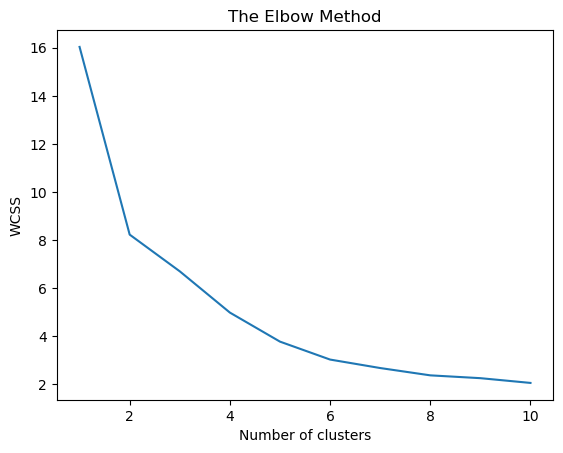

In [194]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
X = df[["rating","duration"]]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

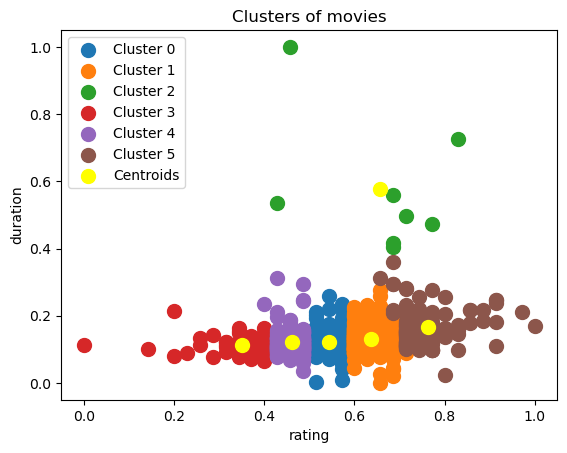

In [195]:
kmeans = KMeans(n_clusters = 6, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(X_scaled)
# Plotting clusters
for i in range(6):  # Assuming there are 5 clusters
    plt.scatter(X_scaled[y_kmeans == i, 0], X_scaled[y_kmeans == i, 1], s=100, label=f'Cluster {i}')

# Plotting the centroids
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=100, c='yellow', label='Centroids')
plt.title('Clusters of movies')
plt.xlabel('rating')
plt.ylabel('duration')
plt.legend()
plt.show()



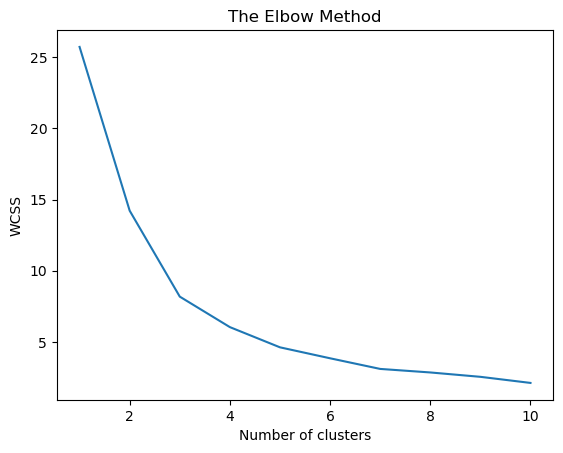

In [196]:
X = df[["rating","voteCount"]]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
warnings.filterwarnings("ignore", category=UserWarning)
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

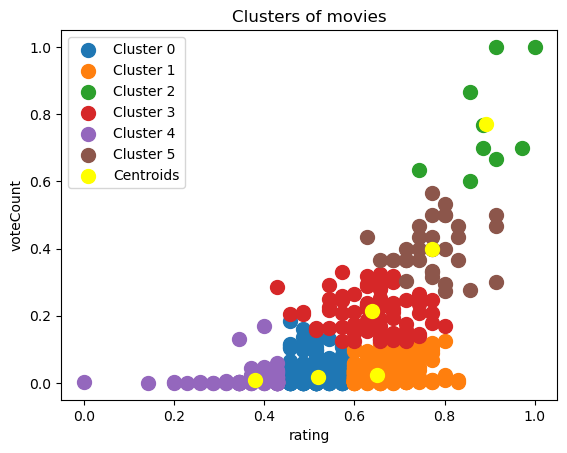

In [197]:
kmeans = KMeans(n_clusters = 6, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(X_scaled)
# Plotting clusters
for i in range(6):  # Assuming there are 5 clusters
    plt.scatter(X_scaled[y_kmeans == i,0], X_scaled[y_kmeans == i,1], s=100, label=f'Cluster {i}')

# Plotting the centroids
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=100, c='yellow', label='Centroids')
plt.title('Clusters of movies')
plt.xlabel('rating')
plt.ylabel('voteCount')
plt.legend()
plt.show()


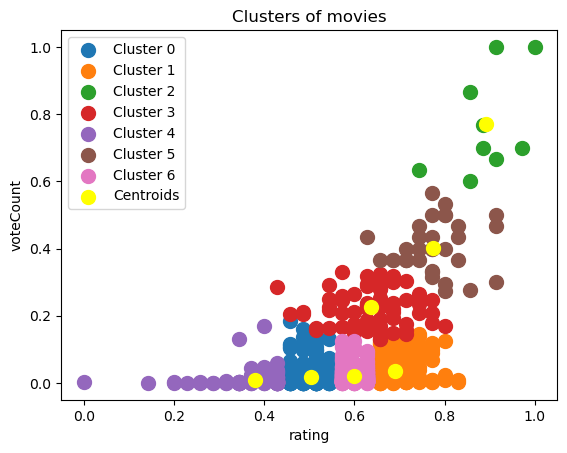

In [198]:
kmeans = KMeans(n_clusters = 7, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(X_scaled)
# Plotting clusters
for i in range(7):  # Assuming there are 5 clusters
    plt.scatter(X_scaled[y_kmeans == i, 0], X_scaled[y_kmeans == i,1], s=100, label=f'Cluster {i}')

# Plotting the centroids
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=100, c='yellow', label='Centroids')
plt.title('Clusters of movies')
plt.xlabel('rating')
plt.ylabel('voteCount')
plt.legend()
plt.show()


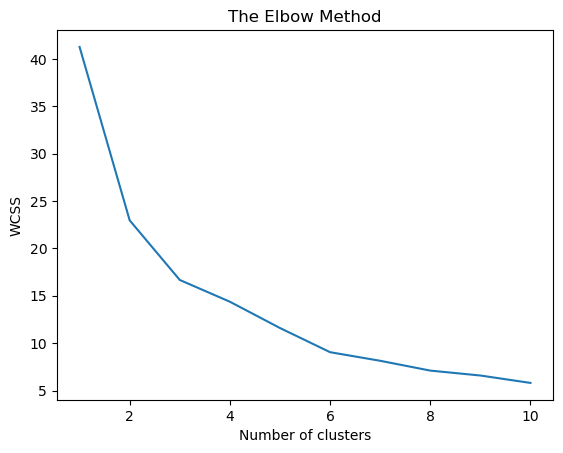

In [199]:
X = df[["rating","Metascore"]]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
warnings.filterwarnings("ignore", category=UserWarning)
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

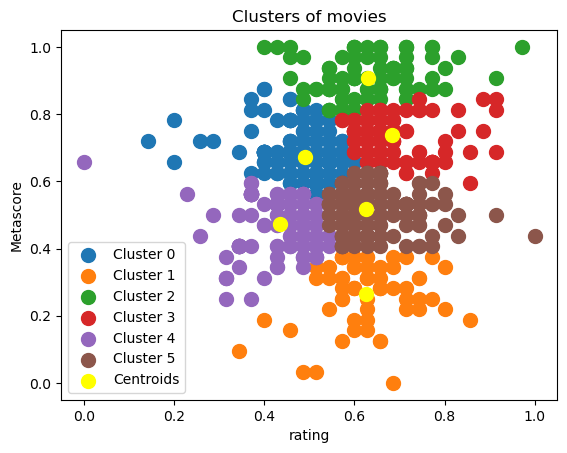

In [200]:
kmeans = KMeans(n_clusters = 6, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(X_scaled)
#### Plotting clusters
for i in range(6):  # Assuming there are 5 clusters
    plt.scatter(X_scaled[y_kmeans == i, 0], X_scaled[y_kmeans == i,1], s=100, label=f'Cluster {i}')

# Plotting the centroids
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=100, c='yellow', label='Centroids')
plt.title('Clusters of movies')
plt.xlabel('rating')
plt.ylabel('Metascore')
plt.legend()
plt.show()


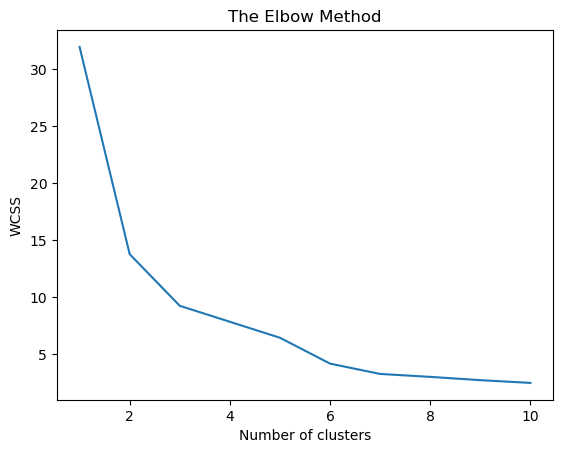

In [201]:
X = df[["Metascore","duration"]]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
warnings.filterwarnings("ignore", category=UserWarning)
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

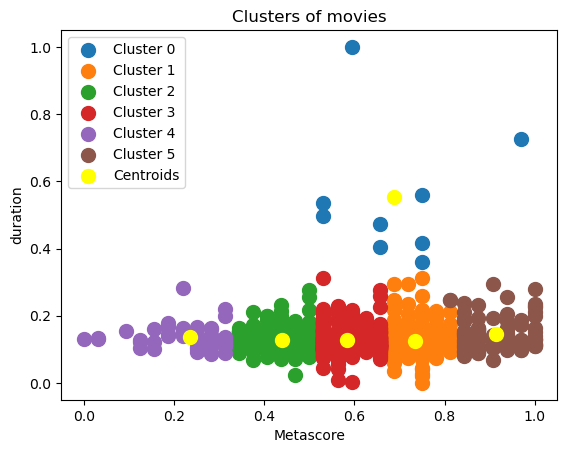

In [202]:
kmeans = KMeans(n_clusters = 6, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(X_scaled)
# Plotting clusters
for i in range(6):  # Assuming there are 5 clusters
    plt.scatter(X_scaled[y_kmeans == i, 0], X_scaled[y_kmeans == i,1], s=100, label=f'Cluster {i}')

# Plotting the centroids
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=100, c='yellow', label='Centroids')
plt.title('Clusters of movies')
plt.xlabel('Metascore')
plt.ylabel('duration')
plt.legend()
plt.show()

In [203]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import euclidean_distances
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
dataset = df.copy()
# List of available feature pairs for clustering
feature_options = {
    1: ['rating', 'voteCount'],
    2: ['rating', 'Metascore'],
    3: ['rating', 'year'],
    4: ['rating', 'duration'],
    5: ['voteCount', 'Metascore'],
    6: ['voteCount', 'year'],
    7: ['voteCount', 'duration'],
    8: ['Metascore', 'year'],
    9: ['Metascore', 'duration'],
    10: ['year', 'duration'],
}

# Display the options for the user to select a feature pair
print("Available feature options for clustering:")
for key, value in feature_options.items():
    print(f"{key}: {value[0]} and {value[1]}")

# Ask the user to choose a feature pair
user_choice = int(input("Choose the number corresponding to your desired feature pair (1, 2, 3,...,10): "))

# Get the selected feature pair based on the user's choice
selected_features = feature_options.get(user_choice)

# Print the selected features
print(f"You selected the features: {selected_features[0]} and {selected_features[1]}")

# Select the data based on the chosen features
X = dataset[selected_features]

# Scale the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Train the KMeans model
kmeans = KMeans(n_clusters=6, init='k-means++', random_state=42)
kmeans.fit(X_scaled)

# Add the cluster label to the dataset
dataset['cluster'] = kmeans.labels_

# Function to find the closest 3 movies based on user input
def find_closest_movies(user_values, selected_features):
    # Scale the user input values
    user_values_scaled = scaler.transform([user_values])
    
    # Find the cluster that the user input belongs to
    cluster_label = kmeans.predict(user_values_scaled)[0]
    
    # Filter the movies belonging to the same cluster
    same_cluster_movies = dataset[dataset['cluster'] == cluster_label].copy()  # Create a copy to avoid warning
    
    # Get the feature values for the same cluster movies
    same_cluster_movies_features = same_cluster_movies[selected_features]
    
    # Calculate the Euclidean distance between the user input and each movie in the same cluster
    distances = euclidean_distances(user_values_scaled, scaler.transform(same_cluster_movies_features))
    
    # Add the distance column safely
    same_cluster_movies['distance'] = distances[0]
    
    # Sort by distance and get the closest 3 movies
    closest_movies = same_cluster_movies.sort_values(by='distance').head(3)
    
    return closest_movies

# Ask the user for input values based on the selected features
user_values = []
for feature in selected_features:
    user_value = float(input(f"Enter the value for {feature}: "))
    user_values.append(user_value)

# Find the closest 3 movies
closest_movies = find_closest_movies(user_values, selected_features)

# Display the closest movies
print("\nThe closest 3 movies to your input are:")
print(closest_movies[['title', *selected_features, 'movielink']])


Available feature options for clustering:
1: rating and voteCount
2: rating and Metascore
3: rating and year
4: rating and duration
5: voteCount and Metascore
6: voteCount and year
7: voteCount and duration
8: Metascore and year
9: Metascore and duration
10: year and duration


Choose the number corresponding to your desired feature pair (1, 2, 3,...,10):  3


You selected the features: rating and year


Enter the value for rating:  8.2
Enter the value for year:  1950



The closest 3 movies to your input are:
                        title  rating  year  \
284  The Young and the Damned     8.2  1950   
30                   Rashomon     8.2  1950   
11              All About Eve     8.2  1950   

                                             movielink  
284  https://www.imdb.com/title/tt0042804/?ref_=ls_...  
30   https://www.imdb.com/title/tt0042876/?ref_=ls_...  
11   https://www.imdb.com/title/tt0042192/?ref_=ls_...  


## Regression 

In [94]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [95]:
# linear regresion with duration,voteCount,Metascore,rating,certification, Director, Star1,Star2,'Star3
data = df.copy()
label_encoder = LabelEncoder()

data['Director'] = label_encoder.fit_transform(data['Director'])
data['Star1'] = label_encoder.fit_transform(data['Star1'])
data['Star2'] = label_encoder.fit_transform(data['Star2'])
data['Star3'] = label_encoder.fit_transform(data['Star3'])
data['certification'] = label_encoder.fit_transform(data['certification'])

x = data[['duration', 'voteCount', 'Metascore','certification', 'Director', 'Star1', 'Star2','Star3']]
y = data['rating']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

model = LinearRegression() 
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: ", mse)


Mean Squared Error:  0.1083574134084848


In [96]:
data['rating_class'] = data['rating'].apply(lambda x: 'high' if x > 7 else 'low')
print(data['rating_class'])

# Logistic regresion with duration,voteCount,Metascore,rating,certification, Director, Star1,Star2,'Star3

X = data[['duration', 'voteCount', 'Metascore', 'certification', 'Director', 'Star1', 'Star2', 'Star3']]
y = data['rating_class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = LogisticRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

log_reg_acc = accuracy_score(y_test, y_pred)

print(f"Accuracy: {log_reg_acc}")

log_reg_CM = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(log_reg_CM)

print("Classification Report:")
print(classification_report(y_test, y_pred))


0      high
1      high
2      high
3      high
4      high
       ... 
994     low
995     low
996     low
997     low
998     low
Name: rating_class, Length: 981, dtype: object
Accuracy: 0.9593908629441624
Confusion Matrix:
[[189   0]
 [  8   0]]
Classification Report:
              precision    recall  f1-score   support

        high       0.96      1.00      0.98       189
         low       0.00      0.00      0.00         8

    accuracy                           0.96       197
   macro avg       0.48      0.50      0.49       197
weighted avg       0.92      0.96      0.94       197



#### RandomForest

In [97]:
#RandomForestMent feature duration,voteCount,Metascore,rating,certification, Director, Star1,Star2,'Star3
X = data[['duration', 'voteCount','Metascore','certification', 'Director', 'Star1', 'Star2','Star3']]
y = data['rating']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

MSE = mean_squared_error(y_test, y_pred)
R2 = r2_score(y_test, y_pred)

print("Mean Squared Error:" , MSE)
print("R-squared:",R2)


Mean Squared Error: 0.0936369999999997
R-squared: 0.32532307759430734


#### Naive Bayes

In [98]:

X = data[['duration', 'voteCount', 'Metascore', 'Director', 'Star1', 'Star2', 'Star3']]
y = data['rating']
y = y.apply(lambda x: 'high' if x > 7 else 'low')

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

# Correcting the prediction line
nb_y_pred = nb_model.predict(X_test)

# Correcting the accuracy and confusion matrix lines
nb_acc = accuracy_score(y_test, nb_y_pred)
print(f"Accuracy: {nb_acc}")

nb_CM = confusion_matrix(y_test, nb_y_pred)
print("Confusion Matrix:")
print(nb_CM)

print("\nClassification Report:")
print(classification_report(y_test, nb_y_pred))


Accuracy: 0.949238578680203
Confusion Matrix:
[[186   3]
 [  7   1]]

Classification Report:
              precision    recall  f1-score   support

        high       0.96      0.98      0.97       189
         low       0.25      0.12      0.17         8

    accuracy                           0.95       197
   macro avg       0.61      0.55      0.57       197
weighted avg       0.93      0.95      0.94       197



### KNN

In [99]:

X = data[['duration', 'voteCount', 'Metascore', 'Director', 'Star1', 'Star2', 'Star3']]
y = data['rating']
y = y.apply(lambda x: 'high' if x > 7 else 'low')

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

knn_model = KNeighborsClassifier(n_neighbors=11)  
knn_model.fit(X_train, y_train)

knn_y_pred = knn_model.predict(X_test)

knn_acc = accuracy_score(y_test, knn_y_pred)
print(f"Accuracy: {knn_acc}")

knn_CM = confusion_matrix(y_test, knn_y_pred)
print("Confusion Matrix:")
print(knn_CM)

print("\nClassification Report:")
print(classification_report(y_test, knn_y_pred))


Accuracy: 0.9593908629441624
Confusion Matrix:
[[189   0]
 [  8   0]]

Classification Report:
              precision    recall  f1-score   support

        high       0.96      1.00      0.98       189
         low       0.00      0.00      0.00         8

    accuracy                           0.96       197
   macro avg       0.48      0.50      0.49       197
weighted avg       0.92      0.96      0.94       197



### Decision Tree

In [100]:

X = data[['duration', 'voteCount', 'Metascore']]
y = data['rating']

y = y.apply(lambda x: 'high' if x > 7 else 'low')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dt_model = DecisionTreeClassifier(random_state=42, max_depth=5)
dt_model.fit(X_train, y_train)

dt_y_pred = dt_model.predict(X_test)

dt_acc = accuracy_score(y_test, dt_y_pred)
print("Decision Tree Accuracy ", dt_acc)

dt_CM = confusion_matrix(y_test, dt_y_pred)
print("Confusion Matrix:")
print(dt_CM)

print("\nClassification Report:")
print(classification_report(y_test, dt_y_pred))


Decision Tree Accuracy  0.9695431472081218
Confusion Matrix:
[[188   1]
 [  5   3]]

Classification Report:
              precision    recall  f1-score   support

        high       0.97      0.99      0.98       189
         low       0.75      0.38      0.50         8

    accuracy                           0.97       197
   macro avg       0.86      0.68      0.74       197
weighted avg       0.96      0.97      0.96       197



                 Model  Accuracy
0                  KNN  0.959391
1          Naive Bayes  0.949239
2  Logistic Regression  0.959391
3        Decision Tree  0.969543


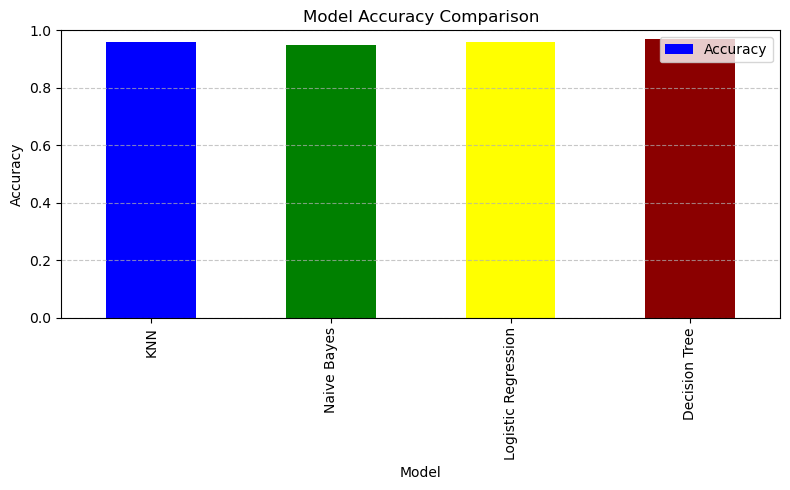

The best model is Decision Tree with an accuracy of 0.97.


In [101]:
import matplotlib.pyplot as plt

metrics_data = {
    'Model': ['KNN', 'Naive Bayes', 'Logistic Regression', 'Decision Tree'],
    'Accuracy': [knn_acc, nb_acc, log_reg_acc, dt_acc]
}

metrics_df = pd.DataFrame(metrics_data)

print(metrics_df)
metrics_df.plot(kind='bar', x='Model', y='Accuracy', color=['blue', 'green', 'yellow', 'darkred'], figsize=(8, 5))

plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Assuming accuracy is between 0 and 1
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
best_model = metrics_df.loc[metrics_df['Accuracy'].idxmax()]
print(f"The best model is {best_model['Model']} with an accuracy of {best_model['Accuracy']:.2f}.")


In [102]:
# Decision Tree - the best model, use the model to make predictions
def get_user_input():
    print("Enter the following details:")
    print("Duration: between 60 and 180 minutes.")
    print("Vote count: between 1000 and 5000000.")
    print("Metascore: between 0 and 100.")

    duration = float(input("Enter movie duration (in minutes): "))
    while duration < 60 or duration > 180:
        print("Invalid input! Duration should be between 60 and 180 minutes.")
        duration = float(input("Enter movie duration (in minutes): "))
    
    voteCount = int(input("Enter vote count: "))
    while voteCount < 1000 or voteCount > 5000000:
        print("Invalid input! Vote count should be between 1000 and 5000000.")
        voteCount = int(input("Enter vote count: "))
    
    metascore = int(input("Enter Metascore: "))
    while metascore < 0 or metascore > 100:
        print("Invalid input! Metascore should be between 0 and 100.")
        metascore = int(input("Enter Metascore: "))
    
    return [duration, voteCount, metascore]

user_input = get_user_input()

import pandas as pd
user_input_df = pd.DataFrame([user_input], columns=['duration', 'voteCount', 'Metascore'])

user_prediction = dt_model.predict(user_input_df)

print(f"The predicted rating category for this movie is: {user_prediction[0]}")


Enter the following details:
Duration: between 60 and 180 minutes.
Vote count: between 1000 and 5000000.
Metascore: between 0 and 100.


Enter movie duration (in minutes):  550


Invalid input! Duration should be between 60 and 180 minutes.


Enter movie duration (in minutes):  60
Enter vote count:  8


Invalid input! Vote count should be between 1000 and 5000000.


Enter vote count:  7


Invalid input! Vote count should be between 1000 and 5000000.


Enter vote count:  10000
Enter Metascore:  400


Invalid input! Metascore should be between 0 and 100.


Enter Metascore:  12


The predicted rating category for this movie is: high


### MONGO DB AND REGEX

In [208]:
# Import Libraries
import pandas as pd
from pymongo import MongoClient


# MongoDB connection
client = MongoClient("mongodb://localhost:27017/")  # Update with your MongoDB URI
db = client["moviesDB"]  # Database name
collection = db["moviesCollection"]  # Collection name

# Load CSV into MongoDB
def load_csv_to_mongo():
    try:
        if collection.count_documents({}) > 0:  # Check if data already exists in the collection
            print("Data already loaded into the database.")
            return
        data = df.to_dict(orient="records")  # Convert to dictionary format
        collection.insert_many(data)  # Insert all records at once
        print(f"Successfully imported {len(data)} records into the database.")
    except Exception as e:
        print(f"Error loading CSV: {e}")

# View record details in the desired format
def view_record_details(record):
    print(f"\nTitle: {record['title']}")
    print(f"Year: {record['year']}")
    print(f"Duration: {record['duration']} minutes")
    print(f"Certification: {record['certification']}")
    print(f"Rating: {record['rating']}")
    print(f"Vote Count: {record['voteCount']}")
    print(f"Metascore: {record['Metascore']}")
    print(f"Description: {record['Description']}")
    print(f"Director: {record['Director']}")
    print(f"Movie Link: {record['movielink']}")
    
    # Print Stars if they exist
    if 'Star1' in record and 'Star2' in record and 'Star3' in record:
        print(f"Stars: {record['Star1']}, {record['Star2']}, {record['Star3']}")

# Search records
def search_records():
    valid_fields = ["title", "year", "duration", "certification", "rating", "voteCount", "Metascore", "Description", "Director", "movielink", "Star1", "Star2", "Star3"]
    
    field = input("Enter the field to search by (title, Director, voteCount, .....): ").strip().lower()

    # Ensure the field is valid
    valid_fields_lower = [field_name.lower() for field_name in valid_fields]
    if field not in valid_fields_lower:
        print(f"Invalid field name '{field}'. Please enter one of the following valid fields: {', '.join(valid_fields)}")
        return
    
    actual_field = valid_fields[valid_fields_lower.index(field)]
    value = input(f"Enter the value to search for in {actual_field}: ").strip()

    print(f"Searching for field: {actual_field}, value: {value}")  # Debug: Print normalized inputs

    # Check field type and convert value accordingly
    if actual_field in ["year", "voteCount", "Metascore", "duration", "rating"]:
        try:
            if '.' in value:
                value = float(value)
            else:
                value = int(value)
        except ValueError:
            print(f"Invalid value for {actual_field}. Please enter a valid number.")
            return
        results = collection.find({actual_field: value})
    elif actual_field == "certification":
        # For the "certification" field, match exactly (case-insensitive)
        results = collection.find({actual_field: {"$regex": f"^{value}$", "$options": "i"}})
    else:
        # For other string fields like Director, movielink, use regex for partial matching and case-insensitivity
        results = collection.find({actual_field: {"$regex": value, "$options": "i"}})

    found = False
    for result in results:
        found = True
        print(f"Matching Record:  ")
        view_record_details(result)
    
    if not found:
        print("No matching records found.")

# View all records
def view_all_records():
    records = collection.find()
    if collection.count_documents({}) > 0:  # Check if there are records in the collection
        for record in records:
            view_record_details(record)  # Print each record's details in the desired format
    else:
        print("No records found.")

# Add a new record
def add_record():
    print("Enter details for the new movie:")
    new_record = {
        "title": input("Title: ").strip(),
        "year": int(input("Year: ").strip()),
        "duration": float(input("Duration (in minutes): ").strip()),
        "certification": input("Certification: ").strip(),
        "rating": float(input("Rating: ").strip()),
        "voteCount": int(input("Vote Count: ").strip()),
        "Metascore": float(input("Metascore: ").strip()),
        "Description": input("Description: ").strip(),
        "Director": input("Director: ").strip(),
        "movielink": input("Movie Link: ").strip(),
        "Star1": input("Star 1: ").strip(),
        "Star2": input("Star 2: ").strip(),
        "Star3": input("Star 3: ").strip()
    }
    if not collection.find_one({"title": {"$regex": f"^{new_record['title']}$", "$options": "i"}}):
        collection.insert_one(new_record)
        print(f"Record for '{new_record['title']}' added successfully.")
        view_record_details(new_record)  # Display the added record
    else:
        print("A record with this title already exists.")

# Update a record
def update_record():
    title = input("Enter the title of the movie to update: ").strip().lower()
    record = collection.find_one({"title": {"$regex": f"^{title}$", "$options": "i"}})
    if record:
        print("Existing details:", record)
        field_to_update = input("Enter the field to update (rating, Director, .....): ").strip()
        new_value = input(f"Enter the new value for {field_to_update}: ").strip()
        collection.update_one({"_id": record["_id"]}, {"$set": {field_to_update: new_value}})
        print(f"Record updated. New {field_to_update}: {new_value}")
        updated_record = collection.find_one({"_id": record["_id"]})  # Retrieve the updated record
        view_record_details(updated_record)  # Display the updated record
    else:
        print("Movie not found.")

# Delete a record
def delete_record():
    # Get the full title input, removing leading/trailing spaces and making it case-insensitive
    title = input("Enter the full title of the movie to delete: ").strip().lower()
    
    # Find the movie record using a case-insensitive regex match
    result = collection.delete_one({"title": {"$regex": f"^{title}$", "$options": "i"}})
    
    # Check if a record was deleted
    if result.deleted_count > 0:
        print(f"Record for '{title}' deleted successfully.")
    else:
        print("Movie not found.")

# Main menu
def main_menu():
    while True:
        print("\nMovie Database System")
        print("1. Load CSV to MongoDB")
        print("2. View all records")
        print("3. Search for a record")
        print("4. Add a new record")
        print("5. Update a record")
        print("6. Delete a record")
        print("7. Exit")
        choice = input("Enter your choice: ").strip()
        
        if choice == "1":
            load_csv_to_mongo()
        elif choice == "2":
            view_all_records()
        elif choice == "3":
            search_records()
        elif choice == "4":
            add_record()
        elif choice == "5":
            update_record()
        elif choice == "6":
            delete_record()
        elif choice == "7":
            print("Exiting... Goodbye!")
            break
        else:
            print("Invalid choice. Please try again.")

# Entry point
if __name__ == "__main__":
    main_menu()



Movie Database System
1. Load CSV to MongoDB
2. View all records
3. Search for a record
4. Add a new record
5. Update a record
6. Delete a record
7. Exit


Enter your choice:  3
Enter the field to search by (title, Director, voteCount, .....):  year
Enter the value to search for in year:  1950


Searching for field: year, value: 1950
No matching records found.

Movie Database System
1. Load CSV to MongoDB
2. View all records
3. Search for a record
4. Add a new record
5. Update a record
6. Delete a record
7. Exit


Enter your choice:  1


Successfully imported 981 records into the database.

Movie Database System
1. Load CSV to MongoDB
2. View all records
3. Search for a record
4. Add a new record
5. Update a record
6. Delete a record
7. Exit


Enter your choice:  3
Enter the field to search by (title, Director, voteCount, .....):  year
Enter the value to search for in year:  1950


Searching for field: year, value: 1950
Matching Record:  

Title: Sunset Boulevard
Year: 1950
Duration: 110 minutes
Certification: Approved
Rating: 8.4
Vote Count: 243000
Metascore: 94
Description: A screenwriter develops a dangerous relationship with a faded film star determined to make a triumphant return.
Director: Billy Wilder
Movie Link: https://www.imdb.com/title/tt0043014/?ref_=ls_i_9
Stars: William Holden,  Gloria Swanson,  Erich von Stroheim
Matching Record:  

Title: All About Eve
Year: 1950
Duration: 138 minutes
Certification: Approved
Rating: 8.2
Vote Count: 142000
Metascore: 98
Description: A seemingly timid but secretly ruthless ingénue insinuates herself into the lives of an aging Broadway star and her circle of theater friends.
Director: Joseph L. Mankiewicz
Movie Link: https://www.imdb.com/title/tt0042192/?ref_=ls_i_12
Stars: Bette Davis,  Anne Baxter,  George Sanders
Matching Record:  

Title: Rashomon
Year: 1950
Duration: 88 minutes
Certification: Not Rated
Rating: 8

Enter your choice:  7


Exiting... Goodbye!


In [104]:
data=df.copy()
data['hero_is_woman'] = data['Description'].str.contains(r'\bwoman\b', case=False, na=False).astype(int)
data['hero_is_man'] = data['Description'].str.contains(r'\bman\b', case=False, na=False).astype(int)

user_choice = input("Enter the gender you want to filter by (woman/man): ").strip().lower()

if user_choice not in ['woman', 'man']:
    print("Invalid choice. Please enter either 'woman' or 'man'.")
else:

    if user_choice == 'woman':
        filtered_df = data[data['hero_is_woman'] == 1]
    else:  
        filtered_df = data[data['hero_is_man'] == 1]


    if filtered_df.empty:
        print(f"No movies found where the hero is a {user_choice}.")
    else:
        print(f"\nMovies where the hero is a {user_choice}:\n")
        for _, row in filtered_df.iterrows():
            print(f"Title: {row['title']}")
            print(f"Link: {row['movielink']}")
            print("-" * 40)


Enter the gender you want to filter by (woman/man):  man



Movies where the hero is a man:

Title: Psycho
Link: https://www.imdb.com/title/tt0054215/?ref_=ls_i_23
----------------------------------------
Title: Bicycle Thieves
Link: https://www.imdb.com/title/tt0040522/?ref_=ls_i_36
----------------------------------------
Title: Mirror
Link: https://www.imdb.com/title/tt0072443/?ref_=ls_i_59
----------------------------------------
Title: The Conformist
Link: https://www.imdb.com/title/tt0065571/?ref_=ls_i_116
----------------------------------------
Title: Umberto D.
Link: https://www.imdb.com/title/tt0045274/?ref_=ls_i_121
----------------------------------------
Title: Spider-Man: Into the Spider-Verse
Link: https://www.imdb.com/title/tt4633694/?ref_=ls_i_125
----------------------------------------
Title: Cool Hand Luke
Link: https://www.imdb.com/title/tt0061512/?ref_=ls_i_133
----------------------------------------
Title: The Cameraman
Link: https://www.imdb.com/title/tt0018742/?ref_=ls_i_139
----------------------------------------
Ti

In [205]:
data['year'] = data['year'].astype(str)

patterns = {
    '30s': r'^193\d',
    '40s': r'^194\d',
    '50s': r'^195\d',
    '60s': r'^196\d',
    '70s': r'^197\d',
    '80s': r'^198\d',
    '90s': r'^199\d',
    '2000s': r'^200\d',
    '2010s': r'^201\d',
    '2020s': r'^202\d'
}

user_input = input("Enter the decade (30s,40s,50s, 60s, 70s, 80s, 90s, 2000s, 2010s, 2020s): ").strip()

if user_input in patterns:
    pattern = patterns[user_input]
    matches = data[data['year'].str.contains(pattern)]
    
    if not matches.empty:
        print("\nMovies from the selected decade:\n")
        for _, row in matches.iterrows():
            print(f"Title: {row['title']}\nLink: {row['movielink']}\n\n")
    else:
        print("No movies found for the selected decade.")
else:
    print("Invalid input. Please enter a valid decade (30s,40s,50s, 60s, etc.).")


Enter the decade (30s,40s,50s, 60s, 70s, 80s, 90s, 2000s, 2010s, 2020s):  2010s



Movies from the selected decade:

Title: One More Time with Feeling
Link: https://www.imdb.com/title/tt5777628/?ref_=ls_i_74


Title: Toy Story 3
Link: https://www.imdb.com/title/tt0435761/?ref_=ls_i_77


Title: A Separation
Link: https://www.imdb.com/title/tt1832382/?ref_=ls_i_78


Title: The Farewell
Link: https://www.imdb.com/title/tt8637428/?ref_=ls_i_91


Title: They Shall Not Grow Old
Link: https://www.imdb.com/title/tt7905466/?ref_=ls_i_102


Title: Inside Out
Link: https://www.imdb.com/title/tt2096673/?ref_=ls_i_122


Title: Spider-Man: Into the Spider-Verse
Link: https://www.imdb.com/title/tt4633694/?ref_=ls_i_125


Title: Apollo 11
Link: https://www.imdb.com/title/tt8760684/?ref_=ls_i_132


Title: Spotlight
Link: https://www.imdb.com/title/tt1895587/?ref_=ls_i_155


Title: 12 Years a Slave
Link: https://www.imdb.com/title/tt2024544/?ref_=ls_i_162


Title: Boyhood
Link: https://www.imdb.com/title/tt1065073/?ref_=ls_i_167


Title: Shoplifters
Link: https://www.imdb.com/title/t

In [206]:
keywords = data['Description'].str.extract(r'(action|drama|comedy|crime|horror|thriller|romance|adventure|sci-fi|fantasy|mystery)', flags=re.IGNORECASE)[0]
data['movie_type'] = keywords.str.lower()

user_input = input("Enter the type of movie you want(action,drama,comedy,crime,horror,thriller,romance,adventure,sci-fi,fantasy,mystery): ").strip().lower()

if user_input in data['movie_type'].unique():
    filtered_movies = data[data['movie_type'] == user_input]
    
    if not filtered_movies.empty:
        print(f"\nMovies of type '{user_input}':\n")
        for _, row in filtered_movies.iterrows():
            print(f"Title: {row['title']}\nLink: {row['movielink']}\n\n")
    else:
        print(f"No movies found of type '{user_input}'.")
else:
    print("Invalid movie type or no movies of the entered type exist.")

Enter the type of movie you want(action,drama,comedy,crime,horror,thriller,romance,adventure,sci-fi,fantasy,mystery):  drama



Movies of type 'drama':

Title: Celine and Julie Go Boating
Link: https://www.imdb.com/title/tt0071381/?ref_=ls_i_646


Title: Floating Clouds
Link: https://www.imdb.com/title/tt0048757/?ref_=ls_i_682


Title: The War Game
Link: https://www.imdb.com/title/tt0059894/?ref_=ls_i_705


Title: Jakten
Link: https://www.imdb.com/title/tt0052939/?ref_=ls_i_777


Title: Beasts of No Nation
Link: https://www.imdb.com/title/tt1365050/?ref_=ls_i_877




### Sorting GUI

In [209]:
import tkinter as tk
from tkinter import ttk
import pandas as pd

def sort_option_selected(event):
    selected_option = sort_var.get()

    # Map sort options to column names in the dataset
    column_mapping = {
        "Alphabetical (A-Z)": "title",
        "IMDb rating": "rating",
        "Number of Ratings": "voteCount",
        "Release Year": "year",
        "Duration": "duration",
        "Certification": "certification",
        "Metascore": "Metascore"
    }

    # Sort the dataset by the selected column if applicable
    if selected_option in column_mapping:
        column_name = column_mapping[selected_option]
        ascending = True  # Always sort ascending by default
        sorted_df = df.sort_values(by=column_name, ascending=ascending)

        # Update the Treeview with sorted data
        for row in tree.get_children():
            tree.delete(row)
        for index, row in sorted_df.iterrows():
            tree.insert("", tk.END, values=list(row))


# Create the main window
root = tk.Tk()
root.title("Movie Sorting Application")

# Create a label
label = tk.Label(root, text="Sort movies by:")
label.pack(pady=5)

# Create a Tkinter StringVar to hold the selected option
sort_var = tk.StringVar()

# Create a dropdown menu
sort_options = ["Alphabetical (A-Z)", "IMDb rating",  "Release Year", "Duration", "Certification", "Metascore"]
dropdown = ttk.Combobox(root, textvariable=sort_var, values=sort_options, state="readonly")
dropdown.current(0)  # Set the default option
dropdown.pack(pady=5)

# Bind the selection event to the function
dropdown.bind("<<ComboboxSelected>>", sort_option_selected)

# Create a frame to hold the Treeview and scrollbar
frame = tk.Frame(root)
frame.pack(pady=10)

# Create a Treeview to display the dataset
tree = ttk.Treeview(frame, columns=list(df.columns), show="headings", height=35)
tree.pack(side=tk.LEFT)

# Add a scrollbar to the Treeview
scrollbar = ttk.Scrollbar(frame, orient=tk.VERTICAL, command=tree.yview)
scrollbar.pack(side=tk.RIGHT, fill=tk.Y)
tree.configure(yscrollcommand=scrollbar.set)

# Add column headings to the Treeview
for col in df.columns:
    tree.heading(col, text=col)
    tree.column(col, width=100)

# Insert initial data into the Treeview
for index, row in df.iterrows():
    tree.insert("", tk.END, values=list(row))


root.mainloop()
